# Write Neural Network from Scratch

TO DO: 
- Drop out layer
- Parameter Update
- Hyperparam optimization

# 1. Define Gates (Add, Multiply)

## Notations
- WX --> **WX** <br/>
- WX + b --> **S** <br/>
- dL / d(WX) = **dWX ** <br/>
- dL / d(S) = **dS** <br/>

Math: http://cs231n.github.io/optimization-2/

In [1]:
class Mul:
    def forward(self, W, X):
        return np.dot(X, W)
    
    def backward(self, W, X, dWX):
        dW = np.dot( np.transpose(X), dWX )
        dX = np.dot( dWX, np.transpose (W))
        return dW, dX

In [2]:
class Add:
    def forward(self, WX, b):
        return WX + b

    def backward(self, WX, b, dS):
        dWX = dS * np.ones_like(WX, dtype=np.float64)
        db = np.dot(np.ones((1, dS.shape[0]), dtype=np.float64), dS)
        return db, dWX

# 2. Define Activaton Functions (Sigmoid, Tanh, Softmax)

Activation(S)  --> **Z** <br/>
Input: 
dL / d(Z) = **dZ** <br/>
Output:
dL / d(S) = **dS** <br/>



In [3]:
class Tanh:
    def forward(self, S):
        Z = np.tanh(S)
        return Z
    
    def backward(self, S, dZ):
        Z = self.forward(S)
        dS = (1.0 - np.square(Z)) * dZ
        return dS

In [4]:
class Sigmoid:
    def forward(self, S):
        Z = 1. / (1.0 + np.exp(-S))
        return Z
    
    def backward(self, S, dZ):
        Z = self.forward(S)
        dS =(1 - Z) * Z * dZ
        return dS

$
\hat{y_{k}} = softmax(S_1, S_2, ..., S_{k}) \\
\mathbf{E} = - \sum_{i=1}^N y_{ik} log(\hat{y_{ik}} )\\
for\ each\ sample\ i: \\
\frac{\partial\mathbf{E}}{\partial S_{k}} = {\hat y}_{k} - y_{k},\ where\ y_{k} = 0, 1\\
$

In [5]:
class Softmax:
    # For Training
    def __init__(self):
        self.num_examples = 0
    
    def forward(self, S):
        self.num_examples = S.shape[0]
        exp_S = np.exp(S)
        Z = exp_S / np.sum(exp_S, axis = 1, keepdims = True)
        return Z

    def backward(self, S, y): # Note: y instead of dZ
        probs = Z = self.forward(S)
        for i in range(len(y)):
            true_label = y[i]
            probs[i][true_label] -= 1 # see equation above
        dS = probs
        return dS
    
    # For evaluation    
    def forward_loss(self, Z, y):
        probs = Z
        log_probs = []
        for prob, true_label in zip(probs, y):
            log_probs.append(np.log(prob[true_label]))
        avg_cross_entropy_loss = - 1. / self.num_examples * np.sum(log_probs) # see equation above
        return avg_cross_entropy_loss
    
    # For prediction
    def predict(self, Z):
        return np.argmax(Z, axis = 1)

### (Optional) Batch Normalization
- **Idea**: Normalize the inputs before activation function for each layer
- **Advantages**: Faster training; still allow scale and shift

<img src="https://kratzert.github.io/images/bn_backpass/bn_algorithm.PNG" width="400">

In [6]:
class BatchNorm:
    def __init__(self):
        self.cache = ()
        
    def forward(self, X, gamma, beta, eps):
        num_examples = X.shape[0]
        
        mu_B = 1. / num_examples * np.sum(X, axis = 0)
        X_mu = X - mu_B
        var_B = 1. / num_examples * np.sum(  X_mu ** 2, axis = 0 )
        sqrt_var_B = np.sqrt(var_B + eps)
        i_sqrt_var_B = 1. / sqrt_var_B
        X_hat =  X_mu * i_sqrt_var_B
        gammaX = gamma * X_hat
        DZ = gammaX + beta
        
        self.cache = (X_hat, X_mu, gamma, i_sqrt_var_B, sqrt_var_B, var_B, eps)
        return DZ
    
    def backward(self, dDZ):
        num_examples = dDZ.shape[0]
        X_hat, X_mu, gamma, i_sqrt_var_B, sqrt_var_B, var_B, eps = self.cache
        
        # scale and shift
        dbeta = np.sum(dDZ, axis = 0)
        dgammaX = dDZ
        dgamma = np.sum(dgammaX * X_hat, axis = 0)
        dXhat = dgammaX * gamma
        
        # Standardize
        di_sqrt_var_B = np.sum(dXhat * X_mu, axis = 0)
        d_x_mu_2 = dXhat * i_sqrt_var_B
        dsqrt_var_B = -1. / (sqrt_var_B ** 2) * di_sqrt_var_B
        dvar_B = 0.5 * 1. / np.sqrt(var_B + eps) * dsqrt_var_B

        # Batch variance
        dsquare = 1. / num_examples * np.ones_like(dDZ) * dvar_B
        d_x_mu_1 = 2 * X_mu * dsquare
        
        # Batch mean
        d_x_mu = d_x_mu_2 + d_x_mu_1 # d(f(x)g(x)) = f(x)g'(x) = f'(x)g(x)
        dmu = -1. * np.sum(d_x_mu, axis = 0)
        dx_2 = d_x_mu
        dx_1 = 1. / num_examples * np.ones_like(dDZ) * dmu
        dx = dx_2 + dx_1
        
        return dx, dgamma, dbeta

In [7]:
# Quick test:
print('Test for 1st input layer: Before normalization: ')
means = np.mean(network.layers[1].S, axis = 0)
stds = np.std(network.layers[1].S, axis = 0)
print('Mean/Std: ', means, stds) 
print('Test for 1st input layer: After normalization: ')
means = np.mean(network.layers[1].SZ, axis = 0)
stds = np.std(network.layers[1].SZ, axis = 0)
print('Mean/Std: ', means, stds) 

Test for 1st input layer: Before normalization: 


NameError: name 'np' is not defined

# 3. Define Layer

### Note: Weights initialization
- **All zero**: wrong: neuron outputs and gradients would be same; same update
- **Number to small**: small gradients for inputs; gradient diminishing for deep NN
- **All neuron with same output distribution**: w = np.random.randn(n) / sqrt(n), where n is number of inputs
    - It can be proved that Var(S) = Var(WX) = Var(X)

In [73]:
class Layer:
    def __init__(self, activation_function, num_neurons, batch_norm = False):
        self.dim = num_neurons
        self.activation = activation_function
        self.batch_norm = batch_norm
        if batch_norm:
            self.batchnorm = BatchNorm()
        self.isfirst = False
        self.islast = False
        self.before = None

    def set_first_layer(self, input):
        self.isfirst = True
        self.X = input
        
    def set_last_layer(self, y):
        self.islast = True
        self.y = y
    
    def initialize_Wb(self):
        if self.isfirst:
            before_dim = self.X.shape[1]
        else:
            before_dim = self.before.dim
        self.W = np.random.randn(before_dim, self.dim) / np.sqrt(before_dim) # see notes above
        self.b = np.random.randn(self.dim).reshape(1, self.dim) # see notes above
        if(self.batch_norm):
            self.gamma, self.beta = (1., 0.)
        
    def forward_propagation(self):
        if not self.isfirst:
            self.X = self.before.Z
        self.WX = Mul().forward( self.W, self.X )
        self.S = Add().forward( self.WX, self.b)
        if self.batch_norm:
            self.SZ = self.batchnorm.forward( self.S, self.gamma, self.beta, eps = 0)
            self.Z = self.activation.forward(self.SZ)
        else:
            self.Z = self.activation.forward(self.S)
            
        
    def backward_propagation(self):
        if self.islast:
            self.dS = self.activation.backward(self.S, self.y)
        else:
            if self.batch_norm:
                self.dSZ = self.activation.backward(self.SZ, self.dZ)
                self.dS, self.dgamma, self.dbeta = self.batchnorm.backward(self.dSZ)
            else:
                self.dS = self.activation.backward(self.S, self.dZ)

        self.db, self.dWX = Add().backward(self.WX, self.b, self.dS)
        self.dW, self.dX = Mul().backward(self.W, self.X, self.dWX)
        if not self.isfirst:
            self.before.dZ = self.dX

    def update_weight(self, learning_rate, lambda_): # see below for other two options besides vanilla update
        self.b += -learning_rate * self.db
        self.W += -learning_rate * self.dW + (- lambda_ * self.W)
        if self.batch_norm:
            self.gamma += -learning_rate * self.dgamma
            self.beta  += -learning_rate * self.dbeta
            
    # Only for softmax layer
    def calculate_loss(self):
        loss = self.activation.forward_loss(self.Z, self.y)
        return loss
        
    def predict(self):
        return self.activation.predict(self.Z)

http://cs231n.github.io/neural-networks-3/<br/>
- Step decay: Reduce the learning rate by some factor every few epochs. Typical values might be reducing the learning rate by a half every 5 epochs, or by 0.1 every 20 epochs. These numbers depend heavily on the type of problem and the model. One heuristic you may see in practice is to watch the validation error while training with a fixed learning rate, and reduce the learning rate by a constant (e.g. 0.5) whenever the validation error stops improving.

- Per-parameter adaptive learning rate methods: Adagrad, Adam

<img src="http://cs231n.github.io/assets/nn3/nesterov.jpeg" width="600">

# 4. Define Network

In [421]:
class Network:
    def __init__(self):
        self.layers = []
        self.input = []
        self.y = []
        
    def add(self, new_layer):
        if self.layers:
            new_layer.before = self.layers[-1]
        self.layers.append(new_layer)
    
    def load_data(self, input, y):
        self.layers[0].set_first_layer(input)
        self.layers[-1].set_last_layer(y)
        
    def initialize(self, input, y, batch_size):
        self.input = input
        self.y = y
        self.load_data(input[:batch_size,:], y[:batch_size])
        for layer in layers:
            layer.initialize_Wb()

    def train(self, num_iter, learning_rate, batch_size, rand_, lambda_):
        loss_ = []
        
        for i in range(num_iter):    
            # Calculate batch index
            if not rand_:
                idx = list(range(self.input.shape[0]))
            else:
                idx = np.random.randint(self.input.shape[0], size = batch_size)
            self.load_data(self.input[idx,:], self.y[idx])
            
            # Forward Propagation
            for layer in self.layers:
                layer.forward_propagation()
                
            # Print Loss
            if (i % 50 == 0):
                loss = layers[-1].calculate_loss()
                loss_.append(loss)
                print('The loss at iteration ', i, ' is: ' , loss)
                
            # Backward Propagation
            for layer in self.layers[::-1]:
                layer.backward_propagation()
                layer.update_weight(learning_rate, lambda_ = lambda_ )
            
        # Finally return loss list
        return loss_
        
    def predict(self, X, return_loss = False):
        self.layers[0].set_first_layer(X)
        for layer in self.layers:
            layer.forward_propagation()
        if return_loss:
            return layers[-1].predict(), layers[-1].calculate_loss()
        else:
            return layers[-1].predict()

<br/>
# 5. Generate some dataset

In [422]:
import sklearn.datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
%matplotlib inline

In [423]:
X, y = make_moons(200, noise = 0.1)
print(X.shape, y.shape)

(200, 2) (200,)


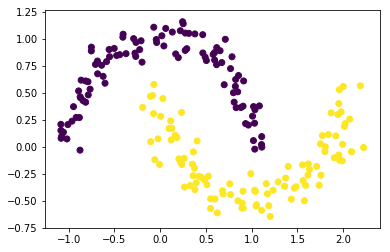

In [424]:
plt.scatter(X[:,0], X[:,1], c = y)

# 6. Design Network

In [425]:
np.random.seed(1)
network = Network()
layers = []

In [426]:
layers.append(Layer(activation_function = Tanh(), num_neurons = 5, batch_norm = True))
layers.append(Layer(activation_function = Tanh(), num_neurons = 5, batch_norm = True))
layers.append(Layer(activation_function = Softmax(), num_neurons = 2))
for layer in layers:
    network.add(layer)

<br/>
# 7. Train network

### Training Parameters

In [427]:
batch_size = 200 # Batch size for gradient update 
num_iter = 1000 # Number of iterations
learning_rate = 0.02 # Learning Rate
lambda_ = 0.011 # Regularization parameter

### Initialize and Train

In [433]:
network.initialize(input = X, y = y, batch_size = batch_size)
loss = network.train(num_iter = num_iter, learning_rate = learning_rate, batch_size = batch_size, rand_ = False, lambda_ = 0)

The loss at iteration  0  is:  0.885347271145
The loss at iteration  50  is:  0.0109931034539
The loss at iteration  100  is:  0.00325527541215
The loss at iteration  150  is:  0.00146149111478
The loss at iteration  200  is:  0.000855968354041
The loss at iteration  250  is:  0.0006129027396
The loss at iteration  300  is:  0.000480197783225
The loss at iteration  350  is:  0.000395867803711
The loss at iteration  400  is:  0.000337282294977
The loss at iteration  450  is:  0.000294102718439
The loss at iteration  500  is:  0.000260903941595
The loss at iteration  550  is:  0.000234554460016
The loss at iteration  600  is:  0.000213115681825
The loss at iteration  650  is:  0.00019532124481
The loss at iteration  700  is:  0.000180307865664
The loss at iteration  750  is:  0.000167466246543
The loss at iteration  800  is:  0.000156353764073
The loss at iteration  850  is:  0.000146640945193
The loss at iteration  900  is:  0.000138077372272
The loss at iteration  950  is:  0.000130469

/Users/shiwang/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


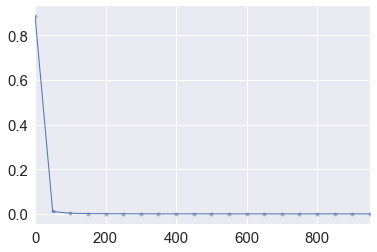

In [450]:
#https://seaborn.pydata.org/generated/seaborn.tsplot.html
import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
iters = list(map(lambda x: x*50,list(range(len(loss)))))
sns.tsplot(loss, iters, err_style = 'unit_points')

# 8. Result Evaluation

## 8.1 Gradient check

The purpose is to confirm that gradient calculation was correct

In [392]:
# Re-initialize network, with same X and y, fixed input, no weight update, no regularization
network.initialize(input = X, y = y, batch_size = batch_size)
network.train(num_iter = 100, learning_rate = 0, batch_size = batch_size, rand_ = False, lambda_ = 0)

The loss at iteration  0  is:  0.877252229499
The loss at iteration  50  is:  0.877252229499


Perturbate X[0,0] by +- 1e5

In [393]:
X_plus = X.copy()
X_plus[0,0] += 1e-5
X_minus = X.copy()
X_minus[0,0] -= 1e-5

Calculate gradient

In [396]:
_, loss_plus = network.predict(X_plus, return_loss = True)
_, loss_minus = network.predict(X_minus, return_loss = True)
c_gradient = (loss_plus - loss_minus) / (2e-5) * X.shape[0]
print('Calculated Gradient: ', c_gradient)

Calculated Gradient:  -0.318886171913


In [398]:
a_gradient = network.layers[0].dX[0,0]
print('Analytical Gradient: ' , a_gradient)

Analytical Gradient:  -0.318886172791


In [399]:
print('Relative error: ', abs(c_gradient - a_gradient) / max(c_gradient, a_gradient))

Relative error:  -2.7549058571e-09


A better implementation will be checking gradients also at following steps, and for all parameters

## 8.2 Visualize Decisoon Boundary

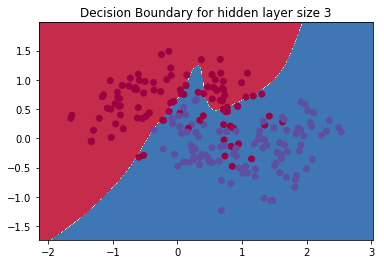

In [234]:
import util.plots
%load_ext autoreload
%autoreload 2
plot_decision_boundary(lambda x: network.predict(x), X, y)
plt.title("Decision Boundary for hidden layer size 3")
plt.show()